In [ ]:
import pandas as pd
import nltk
import html
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.corpus import words
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
#run twice to upload the two csv files
from google.colab import files
uploaded = files.upload()

Saving sentiment_analysis.csv to sentiment_analysis.csv


In [ ]:
sentiment_analysis = open('sentiment_analysis.csv',encoding="utf8").read()
Canadian_elections_2021 = open('Canadian_elections_2021.csv',encoding="utf8").read()

#Data cleaning

In [ ]:
def data_clean(raw_data,col_name1,col_name2,col_name3):
  #col_name parameters are used to adapt to two different structures of data

  cleantext = BeautifulSoup(raw_data, "lxml").text #remove the html tags
  cleantext = html.unescape(cleantext) #convert html entities to ASCII equivalent
  cleantext = cleantext.lower() #convert all characters to lowercase

  cleantext = cleantext.split('\n') #split the string by '\n'

  del cleantext[0] #remove the columns and the last row which does not have data
  del cleantext[-1]

  #use ',' to split the data and put them into dataframe
  if col_name1 == 'tweets': #Canadian election data
    col1 = ["".join(tw.split(',')[0:-2]) for tw in cleantext] 
    col2 = [tw.split(',')[-2] for tw in cleantext]
    col3 = [tw.split(',')[-1] for tw in cleantext]
  elif col_name2 == 'tweets': #sentiment analysis data
    col1 = [tw.split(',')[0] for tw in cleantext] 
    col2 = ["".join(tw.split(',')[1:-1]) for tw in cleantext]
    col3 = [tw.split(',')[-1] for tw in cleantext]  
     
  df=pd.DataFrame({col_name1:col1, col_name2:col2, col_name3:col3})

  df['tweets'] = df['tweets'].replace('http\S+|www.\S+',' ',regex=True) #remove the url

  #use nltk to remove stopwords in each tweet
  nltk.download('punkt')
  stop_words = set(stopwords.words('english'))
  #rt is also a word often appears but useless
  stop_words.add('rt')
  
  tweets=[]

  for tw in df['tweets'].values:
    
    
    word_tokens = word_tokenize(tw)

    filtered_sentence = [w for w in word_tokens if w not in stop_words]
    filtered_sentence=','.join(filtered_sentence)
    tweets.append(filtered_sentence) 
  
  if col_name1 == 'tweets':
    df=pd.DataFrame({col_name1:tweets, col_name2:col2, col_name3:col3})#Canadian election data
  elif col_name2 == 'tweets':
    df=pd.DataFrame({col_name1:col1, col_name2:tweets, col_name3:col3})#sentiment analysis data
  return df

In [ ]:
sentiment=data_clean(sentiment_analysis,'ID','tweets','sentiment')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
sentiment

,ID,tweets,sentiment
0,7.68098e+17,"josh,jenkins,looking,forward,tab,breeders,crow...",1
1,7.68098e+17,"@,mianusmanjaved,:,congratulations,pakistan,be...",1
2,7.68098e+17,"``,@,pepalerts,:,september,@,yesmag,taking,mai...",1
3,7.68098e+17,"``,@,david_gaibis,:,newly,painted,walls,thanks...",1
4,7.68098e+17,"@,cedricfeschotte,:,excited,announce,:,july,20...",1
...,...,...,...
550386,8.04617e+17,"@,goddesses_o,ca,n't,stop,watching,...,mm,.,?,?,?",0
550387,8.04618e+17,"poor,old,tom,odell,n't,look,like,would,know,wr...",0
550388,8.04618e+17,"#,antsmasher,smashed,7,ants,awesome,game,!,!,!...",1
550389,8.04618e+17,"@,lizhudston,@,kymwyllie,@,evasmiless,@,meanbo...",1


In [ ]:
election=data_clean(Canadian_elections_2021,'tweets','sentiment','negative reason')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
election

,tweets,sentiment,negative reason
0,"``,canadian,election,power,grab,pm,trudeau,yes...",negative,calling election early
1,"``,hope,trudeau,loses,canadian,election,tomorr...",negative,covid
2,"``,dear,canadians,election,test,progressive,.,...",positive,
3,"canadian,friends,:,never,forget,trudeau,2,year...",negative,calling election early
4,"sorry,@,thejagmeetsingh,voted,#,ndp,life,elect...",positive,
...,...,...,...
997,"absolutely,horrible,canada,.,forthcoming,elect...",negative,others
998,"``,@,davidakin,trudeau,imposes,gun,control,pol...",negative,gun control
999,"canada,🇨🇦,election,stolen,thugs,.,uneducated,g...",negative,others
1000,"``,o'toole,amends,platform,gun,control,questio...",negative,tell lies


#Exploratory analysis

In [34]:
party=[]
for i in range(election['tweets'].shape[0]):
  tw=election['tweets'][i]
  
  #use explicit words to determine the party first
  if 'votendp' in tw or 'votendp2021' in tw:
    party.append('ndp')
    continue
  if 'voteppc' in tw or 'voteppc2021' in tw:
    party.append('ppc')
    continue
  if 'voteliberal' in tw:
    party.append('liberal')
    continue
  
  #then use related words, but firstly the tweet should be positive, in this case the tweet may tell his favor 
  if election['sentiment'][i]=='positive':

    if 'trudeau' in tw or 'justintrudeau' in tw or 'liberal' in tw:
      party.append('liberal')
      continue
    if 'jagmeetsingh' in tw or 'ndp' in tw or 'ndp2021' in tw:
      party.append('ndp')
      continue
    if 'ppc' in tw or 'ppc2021' in tw or 'maxinebernier' in tw:
      party.append('ppc')
      continue
    if 'erinotoole' in tw or 'otoole' in tw or 'conservative' in tw or "o'toole" in tw:
      party.append('conservative')
      continue
  
  #if not find any related word, we consider we don't know the party of the tweet 
  party.append('unknown')

In [35]:
size=[party.count('unknown'),party.count('liberal'),party.count('ndp'),party.count('ppc'),party.count('conservative')]
label=['unknown','liberal', 'ndp', 'ppc','conservative']
for i in size: int(i)

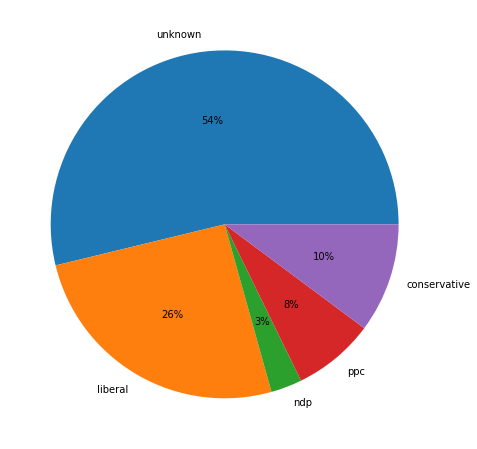

In [36]:
plt.figure(figsize=(8,8))
plt.pie(size,labels=label,autopct='%1.0f%%', pctdistance=0.6, labeldistance=1.1)
plt.show()

From the plot, we can say the descending order of number of supporters is Liberal, Conservative, PPC, NDP. Liberal is still the most popular party. About 50% tweets, we don't know their favor because most of them may be negative and we can't decide what party they are in favor just by the keywords. 

<BarContainer object of 20 artists>

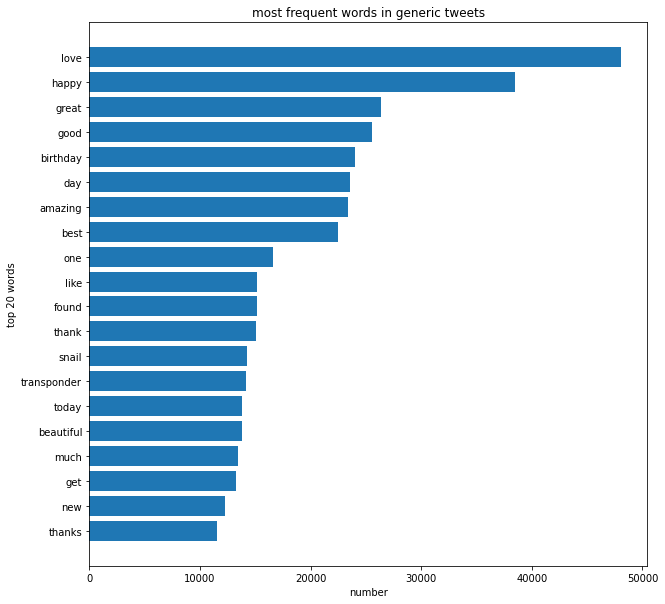

In [37]:
#use bag of words see most frequent words in generic tweets
corpus = sentiment['tweets'].values
vectorizer = CountVectorizer()
vectorizer.fit(corpus)
tokenizer = vectorizer.build_tokenizer()
corpus = ''.join(corpus)
corpus = tokenizer(corpus)

from nltk.probability import FreqDist
freqdist = FreqDist(corpus)
freq = freqdist.most_common(20)
word = [_[0] for _ in freq]
num = [_[1] for _ in freq]
word.reverse()
num.reverse()
plt.figure(figsize=(10,10))
plt.xlabel('number')
plt.ylabel('top 20 words')
plt.title('most frequent words in generic tweets')
plt.barh(word,num)

In [38]:
from wordcloud import wordcloud
wordcloud = wordcloud.WordCloud(collocations = False, prefer_horizontal = 1).generate(" ".join(corpus))

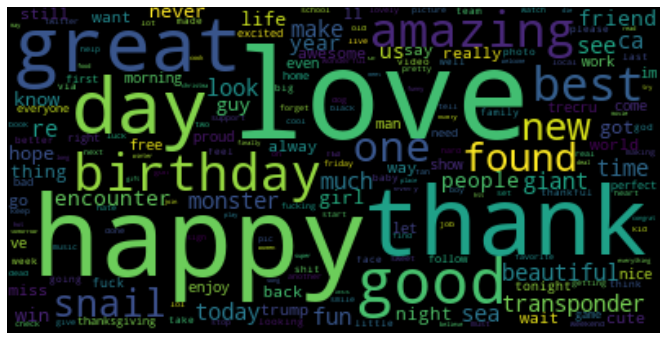

In [39]:
#use word cloud to get a more tuitive look
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show(wordcloud)

We can see most words in the graph are positive words and I think most people using twitter are kind and positive. Love and peace are always important.

In [40]:
sentiment.groupby(sentiment['sentiment']).count()

,ID,tweets
sentiment,,
0,179050,179050
1,371341,371341


We can see that positive tweets are about twice as much as the negative tweets.

Let's see the election data. Positive tweets are also more than negative ones here but not that much as those in generic tweets. I think people are not very satisfied with the election.

In [41]:
election.groupby(election['sentiment']).count()

,tweets,negative reason
sentiment,,
negative,387,387
positive,615,615


<BarContainer object of 20 artists>

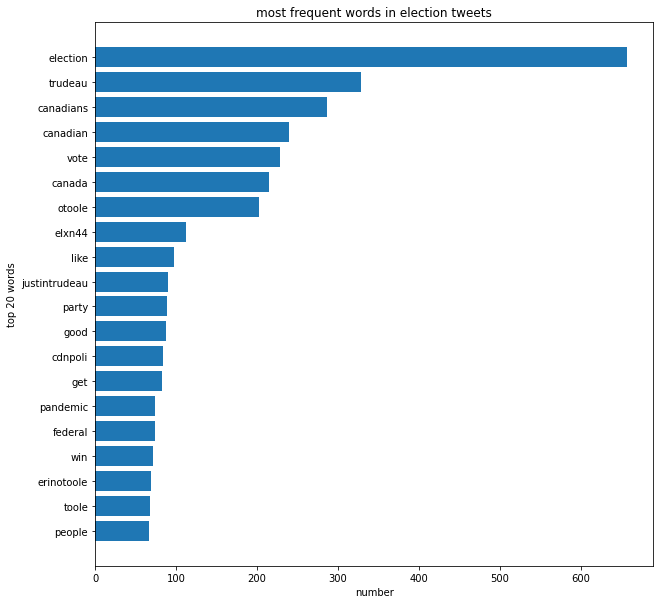

In [42]:
#See most frequent words in Canadian election tweets
corpus = election['tweets'].values
vectorizer = CountVectorizer()
vectorizer.fit(corpus)
tokenizer = vectorizer.build_tokenizer()
corpus = ''.join(corpus)
corpus = tokenizer(corpus)

from nltk.probability import FreqDist
freqdist = FreqDist(corpus)
freq = freqdist.most_common(20)
word = [_[0] for _ in freq]
num = [_[1] for _ in freq]
word.reverse()
num.reverse()
plt.figure(figsize=(10,10))
plt.xlabel('number')
plt.ylabel('top 20 words')
plt.title('most frequent words in election tweets')
plt.barh(word,num)

In [43]:
from wordcloud import wordcloud
wordcloud = wordcloud.WordCloud(collocations = False, prefer_horizontal = 1).generate(" ".join(corpus))

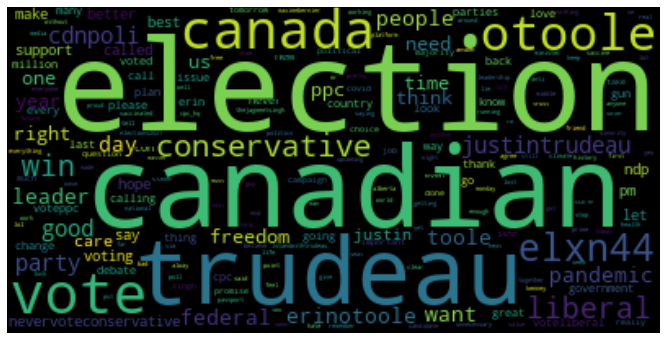

In [44]:
#use word cloud to get a more tuitive look
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show(wordcloud)

The most frequent word is election and that makes sense. The second word is trudeau..and we have to admit that he is really a hot topic. Otoole is another one of the two names in the top 20. We can see pandemic is in the top 20 which we can see the public concern about the covid-19.

#Model preparation

##bag of words and tfidf training function

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

def feature_extraction(df,method):
  corpus=df['tweets'].values
  
  if method == 'bag': #bag of word
    vectorizer = CountVectorizer()
  elif method == 'tfidf': #tfidf
    vectorizer = TfidfVectorizer()
  
  X = vectorizer.fit_transform(corpus)
  y=df['sentiment'].values

  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

  #logistic regression model
  logit_model=LogisticRegression(random_state=0,max_iter=1000).fit(X_train,y_train)
  logit_r_accuracy=logit_model.score(X_test,y_test)

  #knn model
  knn=KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)
  knn_accuracy=knn.score(X_test,y_test)

  #svm model
  svm_model=svm.LinearSVC(max_iter=10000)
  svm_model.fit(X_train,y_train)
  svm_accuracy=svm_model.score(X_test,y_test)


  #naive bayes model
  nb_model=MultinomialNB()
  nb_model.fit(X_train,y_train)
  nb_accuracy=nb_model.score(X_test,y_test)


  #decision tree
  tree_model = tree.DecisionTreeClassifier(random_state=0,max_depth=100)
  tree_model.fit(X_train,y_train)
  tree_accuracy=tree_model.score(X_test,y_test)


  #random forest
  random_forest=RandomForestClassifier(random_state=0,max_depth=100,n_estimators=10)
  random_forest.fit(X_train,y_train)
  random_forest_accuracy=random_forest.score(X_test,y_test)


  #XGboost model
  bst=xgb.XGBClassifier(max_depth=3,n_estimators=200)
  bst.fit(X_train,y_train)
  XGboost_accuracy=bst.score(X_test,y_test)
  
  print('feature extraction method:',method,'\n')
  print('logistic regression accuracy:',logit_r_accuracy)
  print('knn accuracy:',knn_accuracy)
  print('svm accuracy:',svm_accuracy)
  print('naive bayes accuracy:',nb_accuracy)
  print('tree accuracy:',tree_accuracy)
  print('random forest accuracy:',random_forest_accuracy)
  print('XGboost accuracy:',XGboost_accuracy)


#Model implementing and tuning

## part a

In [46]:
#accuracy of 14 models on the generic test data
feature_extraction(sentiment,'bag')
feature_extraction(sentiment,'tfidf')

feature extraction method: bag 

logistic regression accuracy: 0.973443234535302
knn accuracy: 0.897921486452113
svm accuracy: 0.9710812873217941
naive bayes accuracy: 0.9444639591080318
tree accuracy: 0.9230186896643613
random forest accuracy: 0.7423176152811929
XGboost accuracy: 0.8822902409186157
feature extraction method: tfidf 

logistic regression accuracy: 0.9707179108274083
knn accuracy: 0.6118230598723338
svm accuracy: 0.973007182742039
naive bayes accuracy: 0.9090832011046646
tree accuracy: 0.9225281313969403
random forest accuracy: 0.7515170968640609
XGboost accuracy: 0.8823265785680544


In [47]:
corpus=sentiment['tweets'].values

vectorizer = CountVectorizer()
X=vectorizer.fit_transform(corpus)
vol=vectorizer.get_feature_names()

y=sentiment['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [48]:
election_corpus=election['tweets'].values
#bag of words
election_vectorizer = CountVectorizer(vocabulary=vol)
X_election = election_vectorizer.fit_transform(election_corpus)
# convert the 'positive' to 1 and 'negative' to 0
y_election = election['sentiment'].values
y_election=np.where(y_election == 'positive',1,y_election)
y_election=np.where(y_election == 'negative',0,y_election)
y_train=np.where(y_train == '0',0,y_train)
y_train=np.where(y_train == '1',1,y_train)
y_train=y_train.astype(int)
y_election=y_election.astype(int)
y_train,y_election

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


(array([0, 1, 1, ..., 1, 0, 0]), array([0, 0, 1, ..., 0, 0, 0]))

In [49]:
#use logistic regression model and svm on Canadian elections with bag of words feature selection
logit_model=LogisticRegression(random_state=0,max_iter=1000).fit(X_train,y_train)
svm_model=svm_model=svm.LinearSVC(random_state=0,max_iter=10000).fit(X_train,y_train)

In [50]:
print('logical regression accuracy:',logit_model.score(X_election,y_election))
print('svm accuracy:',svm_model.score(X_election,y_election))

logical regression accuracy: 0.6996007984031936
svm accuracy: 0.6856287425149701


In [51]:
#use tfidf and logit regression and svm model on Canadian election data
tfidfvectorizer = TfidfVectorizer()
X = tfidfvectorizer.fit_transform(corpus)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

election_vectorizer = TfidfVectorizer(vocabulary=vol)
X_election = election_vectorizer.fit_transform(election_corpus)

y_train=np.where(y_train == '0',0,y_train)
y_train=np.where(y_train == '1',1,y_train)
y_train=y_train.astype(int)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


In [52]:
logit_model=LogisticRegression(random_state=0,max_iter=1000).fit(X_train,y_train)
svm_model=svm_model=svm.LinearSVC(random_state=0,max_iter=10000).fit(X_train,y_train)

In [53]:
print('logical regression accuracy:',logit_model.score(X_election,y_election))
print('svm accuracy:',svm_model.score(X_election,y_election))

logical regression accuracy: 0.7415169660678643
svm accuracy: 0.7295409181636726


we can see svm model and lr with tfidf features have better performance on Canadian election data and have accuracy about 70% of the sentiment prediction. Not as well as the result on sentiment analysis data itself . We can choose one of the two as model for Canadian election.

Chooose f1 score and confusion matrix here as another two metrics. F1 score can help us see the balance of precision and recall. Confusion matrix can allow us to see  the predictions of each class intuitively.

F1 score: 0.7376573088092934 

confusion matrix:



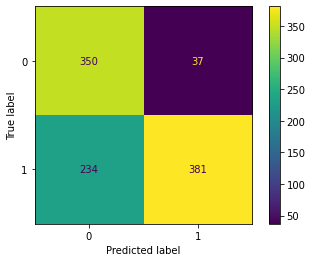

In [54]:
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

pre=svm_model.predict(X_election)
print('F1 score:',f1_score(y_election,pre),'\n')

print('confusion matrix:\n')
disp=ConfusionMatrixDisplay(confusion_matrix(y_election,pre),display_labels=[0,1])
disp=disp.plot(values_format='d')

We can see here the main error is that the estimator predicted some true postive tweets as negtive.

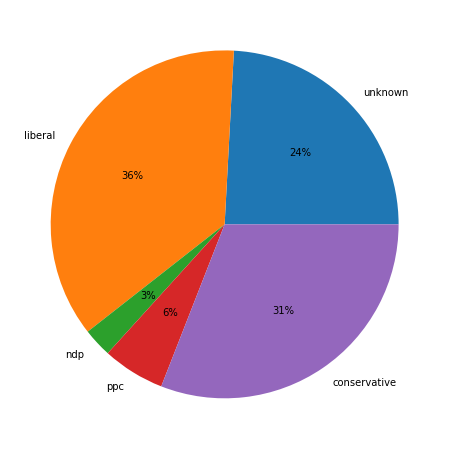

In [55]:
party=[]
for i in range(election['tweets'].shape[0]):
  tw=election['tweets'][i]
  
  #decide the if key words are in the tweets

  if 'nevervoteconservative' in tw or 'otoole' in tw:
    party.append('conservative')
    continue
  if 'votendp' in tw or 'votendp2021' in tw:
    party.append('ndp')
    continue
  if 'voteppc' in tw or 'voteppc2021' in tw:
    party.append('ppc')
    continue
  if 'voteliberal' in tw or 'voteliberalmajority' in tw or 'nevervoteliberal' in tw:
    party.append('liberal')
    continue
  
  #change the order of party to be more equal to all parties

  if 'trudeau' in tw or 'justintrudeau' in tw or 'liberal' in tw:
    party.append('liberal')
    continue
  if 'ppc' in tw or 'ppc2021' in tw or 'maximebernier' in tw:
    party.append('ppc')
    continue
  if 'jagmeetsingh' in tw or 'ndp' in tw or 'singh' in tw or 'ndp2021' in tw:
    party.append('ndp') 
    continue
  if 'erinotoole' in tw or 'conservative' in tw or "o'toole" in tw or 'nevervotecpc' in tw:
    party.append('conservative')
    continue
  
  #if not find any related word, we consider we don't know the party of the tweet 
  party.append('unknown')

size=[party.count('unknown'),party.count('liberal'),party.count('ndp'),party.count('ppc'),party.count('conservative')]
label=['unknown','liberal', 'ndp', 'ppc','conservative']
for i in size: int(i)

plt.figure(figsize=(8,8))
plt.pie(size,labels=label,autopct='%1.0f%%', pctdistance=0.6, labeldistance=1.1)
plt.show()

In [56]:
predictions = ['positive' if x==1 else 'negative' for x in pre ]
party_sentiment = pd.DataFrame({'party':party,'true sentiment':election['sentiment'].values,'predict sentiment':predictions})
index_unknown = party_sentiment.query("party == 'unknown'").index
party_sentiment = party_sentiment.drop(index = index_unknown)
display(party_sentiment)

,party,true sentiment,predict sentiment
0,liberal,negative,negative
1,liberal,negative,negative
3,liberal,negative,negative
4,ppc,positive,negative
5,conservative,negative,negative
...,...,...,...
993,conservative,negative,negative
995,liberal,negative,negative
998,conservative,negative,negative
1000,conservative,negative,negative


Text(0.5, 1.0, 'predict sentiment')

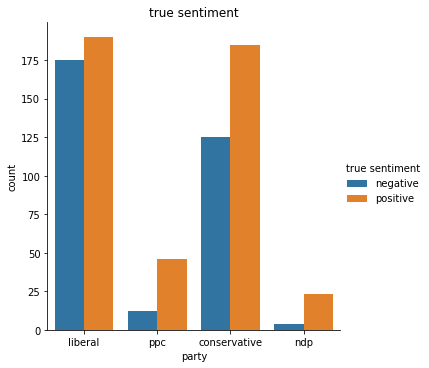

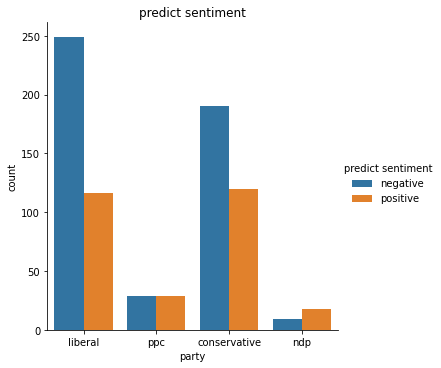

In [57]:
#we can see true sentiment and predict sentiment with different parties here
import seaborn as sns
sns.catplot(x="party", hue="true sentiment", kind="count", data=party_sentiment)
plt.title('true sentiment')
sns.catplot(x="party", hue="predict sentiment", kind="count", data=party_sentiment)
plt.title('predict sentiment')

The result is helpful for parties to analyze the situation conservatively, because it will exaggerate the negative member. But it will help the headers to make decisons if they do some additional optimization of the result.

PPC is the party which has good reputation but not much attention. Liberal has polarized reputation and support situation and so does conservative. NDP's opponents may be little but also lack attention.

## part b 

In [58]:
#select negtive tweets
neg_election=election.query("sentiment == 'negative'")
neg_election

,tweets,sentiment,negative reason
0,"``,canadian,election,power,grab,pm,trudeau,yes...",negative,calling election early
1,"``,hope,trudeau,loses,canadian,election,tomorr...",negative,covid
3,"canadian,friends,:,never,forget,trudeau,2,year...",negative,calling election early
5,"``,vaccines,&,guns,key,election,o'toole,seriou...",negative,covid
6,"``,’,sorry,moderators,respond,leadership,candi...",negative,others
...,...,...,...
997,"absolutely,horrible,canada,.,forthcoming,elect...",negative,others
998,"``,@,davidakin,trudeau,imposes,gun,control,pol...",negative,gun control
999,"canada,🇨🇦,election,stolen,thugs,.,uneducated,g...",negative,others
1000,"``,o'toole,amends,platform,gun,control,questio...",negative,tell lies


In [59]:
#use bag of words for the data and split it to train and test data
corpus = neg_election['tweets'].values
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
y = neg_election['negative reason']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [60]:
#select logistic regression model which performed well before
#the hyperparameters don't have much influence on the result, C is the most important hyperparameter here and C=1 gives the highest accuracy
logit_model=LogisticRegression(penalty='l2',random_state=0,max_iter=1000,solver='newton-cg',C=1).fit(X_train,y_train)
logit_r_accuracy=logit_model.score(X_test,y_test)
pre = logit_model.predict(X_test)
print('accuracy:',logit_r_accuracy)

accuracy: 0.47863247863247865


In [61]:
negative_reason = pd.DataFrame({'true reason':y_test,'predict reason':pre})

In [62]:
negative_reason #we can see the true reason and predict reason here

,true reason,predict reason
93,healthcare and marijuana,others
562,economy,calling election early
921,gun control,others
726,others,others
887,others,tell lies
...,...,...
520,climate problem,climate problem
909,scandal,others
658,calling election early,others
668,calling election early,calling election early


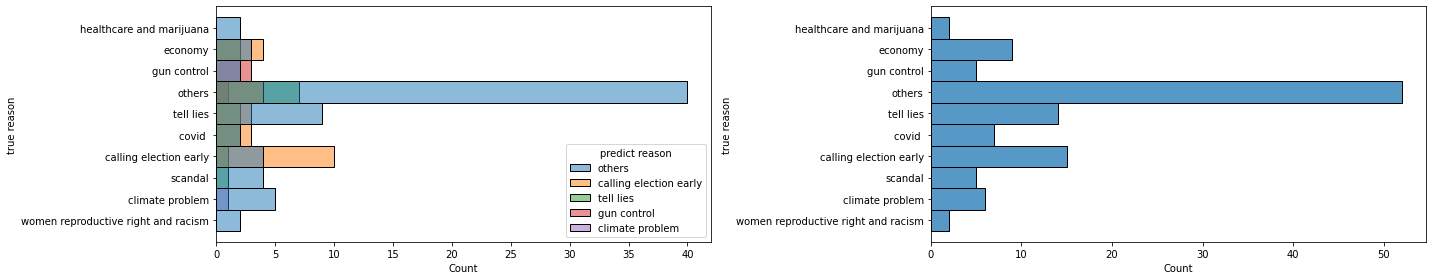

In [63]:
#visualize the result
f, axs = plt.subplots(1, 2, figsize=(20, 4))
sns.histplot(y='true reason',hue='predict reason',data=negative_reason,ax=axs[0])
sns.histplot(y='true reason',data=negative_reason,ax=axs[1])
f.tight_layout()

First reason of the low accuracy I think is the training dataset is small and some reasons can not provide enough words to the volcabulary.
We can see many reasons with small number of samples are predicred as 'others' which has the dominate number.

Another reason is I think is that some reasons have words overlaped. For example, the estimator is confused with 'calling election early' and 'economy'. Maybe the features of the two reasons are similar and we can solve this by combining some reasons.

In [64]:
neg_election.groupby(neg_election['negative reason']).count()['tweets']

negative reason
calling election early                  73
climate problem                         15
covid                                   25
economy                                 20
gun control                             16
healthcare and marijuana                 7
others                                 149
scandal                                 14
segregation                              3
tell lies                               61
women reproductive right and racism      4
Name: tweets, dtype: int64

We can see there are not many differences between the two examples below. The 'covid' reason only has a covid keyword but it's only one word and the influence is limited.

In [65]:
neg_election.iloc[1][0] #this is a negative tweet with 'covid' as reason

"``,hope,trudeau,loses,canadian,election,tomorrow,called,snap,one,thinking,’,romp,it..,seems,people,’,like,black,face,hypocrite,super,wokist,&,covid,restriction,groupie..,let,’,hope,polls,right,might,make,government,think,.,''"

In [66]:
neg_election.iloc[4][0] #'others' as reason

"``,’,sorry,moderators,respond,leadership,candidates,’,?,debate,farce,frankly,disservice,canadians,awful,2019,formats,hope,next,election,see,new,moderation,format,.,’,two,goes,’,enough,.,#,elxn44,#,cdnpoli,''"

I think we should increase the size of input data and more balanced data. Or we can combine some reasons especially combine some minor reasons to the major reasons which are similar to them.

In [67]:
# combine similar reasons from two aspects
# firtly according to the predictions I combine reasons which the estimator confused with each other
# secondly combine some reasons which are reasonable as a more general reason
def change_reason(reason): 
  if reason == 'others' or reason == 'healthcare and marijuana' or reason == 'women reproductive right and racism' or reason == 'segregation':
    reason = 'others'
    return reason
  elif reason == 'calling election early' or reason == 'economy' or reason == 'covid ':
    reason = 'problems related to life'
    return reason
  elif reason == 'gun control' or reason == 'climate problem':
    reason = 'policy'
    return reason
  elif reason == 'scandal' or reason == 'tell lies':
    reason = 'political problems'
    return reason

new_election = neg_election.copy()
new_election['negative reason'] = new_election['negative reason'].apply(change_reason)

In [68]:
new_election

,tweets,sentiment,negative reason
0,"``,canadian,election,power,grab,pm,trudeau,yes...",negative,problems related to life
1,"``,hope,trudeau,loses,canadian,election,tomorr...",negative,problems related to life
3,"canadian,friends,:,never,forget,trudeau,2,year...",negative,problems related to life
5,"``,vaccines,&,guns,key,election,o'toole,seriou...",negative,problems related to life
6,"``,’,sorry,moderators,respond,leadership,candi...",negative,others
...,...,...,...
997,"absolutely,horrible,canada,.,forthcoming,elect...",negative,others
998,"``,@,davidakin,trudeau,imposes,gun,control,pol...",negative,policy
999,"canada,🇨🇦,election,stolen,thugs,.,uneducated,g...",negative,others
1000,"``,o'toole,amends,platform,gun,control,questio...",negative,political problems


accuracy: 0.6239316239316239


,true reason,predict reason
93,others,others
562,problems related to life,problems related to life
921,policy,policy
726,others,others
887,others,others
...,...,...
520,policy,policy
909,political problems,others
658,problems related to life,problems related to life
668,problems related to life,others


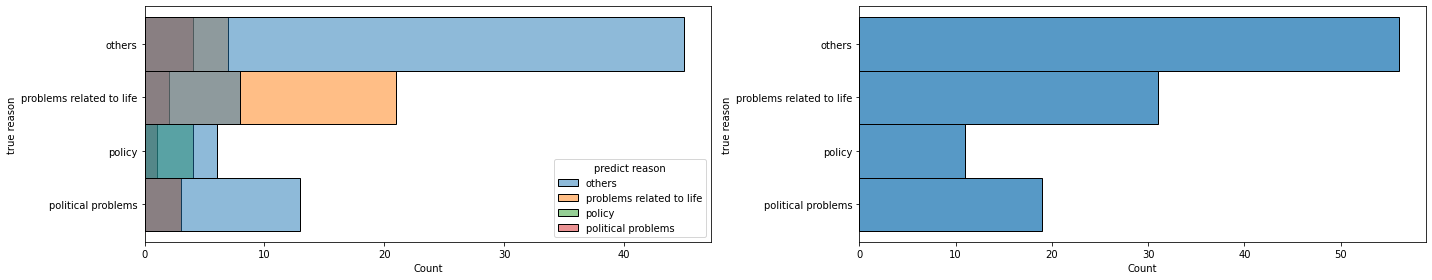

In [69]:
#use the new reasons as target to train again
corpus = new_election['tweets'].values
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
y = new_election['negative reason']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

logit_model=LogisticRegression(penalty='l2',random_state=0,max_iter=1000,solver='newton-cg',C=1).fit(X_train,y_train)
logit_r_accuracy=logit_model.score(X_test,y_test)
pre = logit_model.predict(X_test)
print('accuracy:',logit_r_accuracy)

negative_reason = pd.DataFrame({'true reason':y_test,'predict reason':pre})
display(negative_reason)

f, axs = plt.subplots(1, 2, figsize=(20, 4))
sns.histplot(y='true reason',hue='predict reason',data=negative_reason,ax=axs[0])
sns.histplot(y='true reason',data=negative_reason,ax=axs[1])
f.tight_layout()

we can see the results are better

##part c

In [70]:
#select the positive tweets
pos_election = election.query('sentiment == "positive"')
corpus = pos_election['tweets'].values
vectorizer = CountVectorizer()
vectorizer.fit(corpus)
tokenizer = vectorizer.build_tokenizer()
corpus = ''.join(corpus)
corpus = tokenizer(corpus)

<BarContainer object of 50 artists>

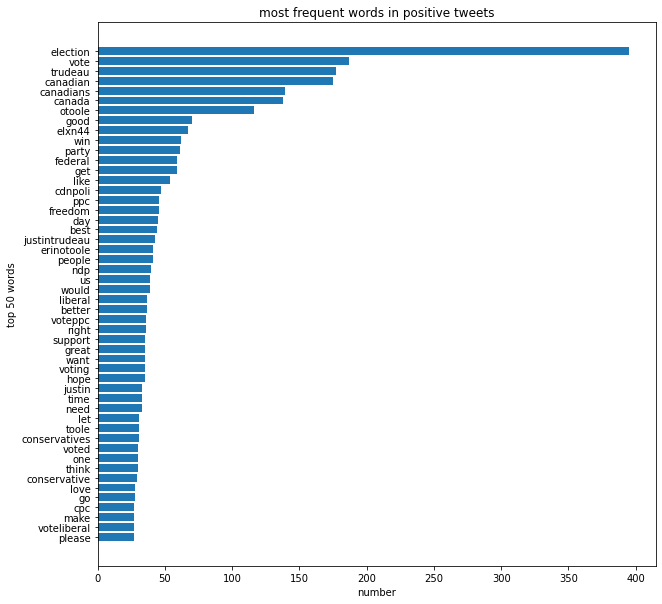

In [71]:
from nltk.probability import FreqDist
freqdist = FreqDist(corpus)
freq = freqdist.most_common(50)
word = [_[0] for _ in freq]
num = [_[1] for _ in freq]
word.reverse()
num.reverse()
plt.figure(figsize=(10,10))
plt.xlabel('number')
plt.ylabel('top 50 words')
plt.title('most frequent words in positive tweets')
plt.barh(word,num)

We can see the most frequent word is 'election' which is followed by vote which is reasonable in election tweets. Tredeau is the 3rd frequent word in positive tweets which suggests he's reputation is not bad. Otoole is also mentioned much in positive tweeets. But we should also take a look at negative tweets.

In [72]:
#Let's see the negtive tweets
neg_election = election.query('sentiment == "negative"')
corpus = neg_election['tweets'].values
vectorizer = CountVectorizer()
vectorizer.fit(corpus)
tokenizer = vectorizer.build_tokenizer()
corpus = ''.join(corpus)
corpus = tokenizer(corpus)

<BarContainer object of 50 artists>

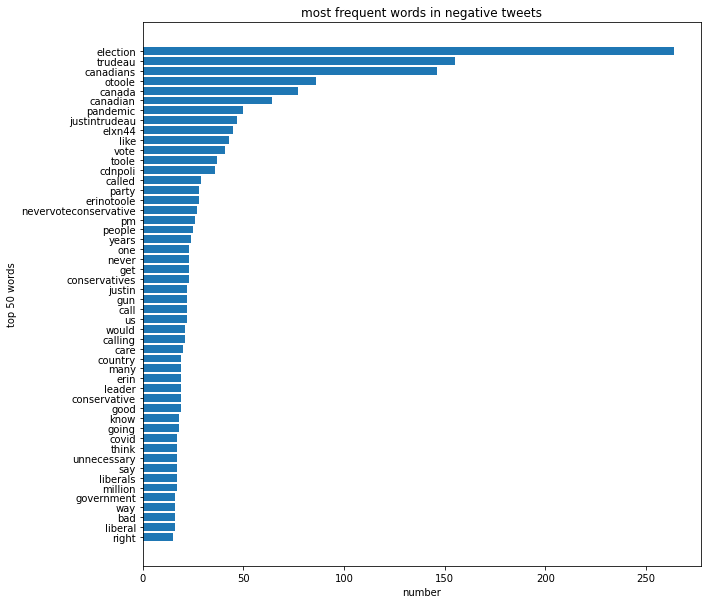

In [73]:
freqdist = FreqDist(corpus)
freq = freqdist.most_common(50)
word = [_[0] for _ in freq]
num = [_[1] for _ in freq]
word.reverse()
num.reverse()
plt.figure(figsize=(10,10))
plt.xlabel('number')
plt.ylabel('top 50 words')
plt.title('most frequent words in negative tweets')
plt.barh(word,num)

The sequence is similar to the positive tweets. From the negative tweets, we can see there are many opponents of trudeau and otoole. The situation is really polarized.